# Quantum Boltzmann Machines

In this section we will introduce a probabilistic model such as the Boltzmann Machine in its quantum version, which generates a distribution P(x) from a set of between-samples and can generate new samples.

## Introduction
 
One focus of machine learning is probabilistic modeling, in which a probability distribution is obtained from a finite set of samples. If the training process is successful, the learned distribution P(x) has sufficient similarity to the actual distribution of the data that it can make correct predictions about unknown situations. Depending on the details of the distributions and the approximation technique, machine learning can be used to perform classification, clustering, compression, denoising, inpainting, or other tasks [[1]](#References). In recent years the popularity of different applications using quantum computing has increased, this tutorial is based on generating one of the machine learning models in order to facilitate training. The purpose of this tutorial is to explain a probabilistic model based on the Boltzmann distribution, i.e. a Quantum Boltzmann Machine (QBM).

    
## Classical Boltzmann Machines

 
Boltzmann Machines (BMs) offer a powerful framework for modelling probability distributions. These types of neural networks use an undirected graph structure to encode relevant information. More precisely,the respective information is stored in bias coefficients and connection weights of network nodes, which are typically related to binary spin-systems and grouped into those that determine the output, the visible nodes, and those that act as latent variables, the hidden nodes [[1],[2]](#References). 

    
    
###  Applications

Applications have been studied in a large variety of domains such as the analysis of quantum manybody systems, statistics, biochemistry, social networks, signal processing and finance [2](#References).

## Quantum Boltzmann Machine 

Quantum Boltzmann Machines (QBMs) [[1]](#References) are a natural adaption of BMs to the quantum computing framework. Instead of an energy function with nodes being




<center>Figure 1. General structure of a QBM.</center>


Quantum Boltzmann Machines (QBMs) are a natural adaption of BMs to the quantum computing framework. Instead of an energy function with nodes being represented by binary spin values, QBMs define the underlying network using a Hermitian operator, a parameterized Hamiltonian


<center>Figure 2. Scheme of the all procces of the QBM  [[3]](#References). </center>




## Implementation
<br>
<div style="text-align: justify"> 
This example is based on the following article : *Benedetti, M., Garcia-Pintos, D., Perdomo, O. et al. A generative modeling approach for benchmarking and training shallow quantum circuits. npj Quantum Inf 5, 45 (2019). https://doi.org/10.1038/s41534-019-0157-8*

To begin this Tutorial we must call the necessary methods to generate circuits and that can be variational as is the case of the class [ParameterVector](https://qiskit.org/documentation/stubs/qiskit.circuit.ParameterVector.html).
</div>

In [1]:
# Qiskit libraries 
# Basic classes for generating quantum circuits
from qiskit import QuantumCircuit, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister

#Class to work with Quantum Variational Circuits
from qiskit.circuit import ParameterVector

#Classes to work with three optimizers
from qiskit.algorithms.optimizers import NELDER_MEAD, SPSA, COBYLA

#Classes to work with plots
from qiskit.tools.jupyter import *
from qiskit.visualization import *

#numpy 
import numpy as np

#Extra graph libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

###  Dataset

Considering the Bars and Stripes (or BAS) dataset, which is composed of binary images of size 2x2, for this tutorial only a subset that is enclosed in a circle is used, as follows


<center>  Figure 3. BAS dataset. </center>



###  Mapping image to qubits

There are various ways of mapping values to qubits as we saw in the Data Encoding section, as these are binary images, i.e. they can only take 2 values, black-white,0-255, 0-1.To work on the quantum computer, the Basis Encoding method will be used to convert images into states, i.e. each pixel is represented as a qubit, being as described in the following figure


<br>
<center>Figure 4. Image to quantum state.</center>


now consider the next conditions:
- if the pixel is white, then the qubit value state is 0,
- if the pixel is Black, then the qubit value state is 1.

For example in Figure 4, the image of size $2 \times 2$ can be rewritten into a matrix<br>

$$\begin{pmatrix}
 c_0r_0 & c_0r_1\\
 c_1r_0 & x_1r_1
\end{pmatrix}.  (1)$$
<br>

Based on the conditions, it can be seen that for the pixel at position $c_0r_0$  is white, and this is equivalent to the qubit $|q_0\rangle$, then its state value is $|0\rangle$; this logic is performed with pixels $c_0r_1$,$c_1r_0$,$c_1r_1$ which are the qubits $|q_1\rangle,|q_2\rangle,|q_3\rangle$ respectively, as they are all white color their  state would be $|0\rangle$ for all of them. The result is the quantum state $|0000\rangle$ of the 4 qubits.




Performing this process for each of the images of the subset would look like this




<center>Figura 5. Mapping the size in qubits.</center>


in total are six quantum states, this can be rewritten as the linear combination, for this purpose it is necessary to consider the characteristic that 

$$\sum_{i=0}^{2^n} | \alpha_i |^2 = 1  \text{  (2)}$$ 

where $n$ is the number of the qubits and $\alpha_i \in \mathbb{C}$ are the scalar values of each state, for this case we consider them purely real, and as each state has the same probability of being measured the following quantum state remains  $|\psi\rangle$,

$$|\psi \rangle =  |\frac{1}{\sqrt{6}} (|0000\rangle+|0011\rangle+|0101\rangle+|1010\rangle+|1100\rangle+|1111\rangle)$$

 which represents a probability distribution $P(x)$.
 
 
**Note:**
 
Check that each  quantum state representate a binary number and that in a decimal value, i.e.:

- $|0000 \rangle => 0000 = 0$
- $|0011 \rangle => 0011 = 3$ 
- $|0101 \rangle => 0101 = 5$ 
- $|1010 \rangle => 1010 = 10$ 
- $|1100 \rangle => 1100 = 12$ 
- $|1111 \rangle => 1111 = 15$ 
 

<div class="alert alert-block alert-info"><b>Question </b> What happens if we use other state of interes with image of size 3x3? </div> 


Starting $P(x)$ with the variable **px_output**, to generate the equivalent state it is necessary that

In [2]:
num_qubits = 4 # number of qubits
init_list = [0,3,5,10,12,15]  #list of indeces of interest 
len_sv = int(num_qubits**2) #the lenght of the statevector 
px_output = np.zeros(len_sv) #init the statevector with zeros of size num_qubits^2

for init_value in init_list: #identify the index of each statevector of interest
    px_output[init_value] = 1/np.sqrt(len(init_list)) #normalize the statevector

px_output #print if is correct  

#px_output = [1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1]/16 expect output

array([0.40824829, 0.        , 0.        , 0.40824829, 0.        ,
       0.40824829, 0.        , 0.        , 0.        , 0.        ,
       0.40824829, 0.        , 0.40824829, 0.        , 0.        ,
       0.40824829])

it is important to prove that the state vector satisfies the characteristics of eq(2), this is possible if we use the next line 

In [3]:
np.sum(px_output**2) ##  is equivalente to | \alpha_i |^2

1.0000000000000002

In order to use the plot_histogram [plot_histogram](https://qiskit.org/documentation/stubs/qiskit.visualization.plot_histogram.html) method, it is important to convert the state vector from a list to a dictionary. and save in the variable   **dict_px_output**

In [141]:
## for use the methods plot_histogram is required use a dictionary

dict_px_output = {}  # the dict variable for the plot_hidtogram 

for elements in  zip(px_output, range(int(num_qubits**2)) ): #did a iteration with the list values and its index
    key = (bin(elements[1])[2:]) #obtain the bin number with the format 0b000, with [:2] remove the values 0b
    while len(key) < num_qubits: # all the keys needs the same lenght that is equal to number of qubits
        key = "0"+key            #add 0 in case the lenght is less than number of qubits  
    dict_px_output[key] = elements[0]  # mapping the index value in a bin number and into a key for the fict

The result must be a uniform distribution for the 6 states: **0000, 0011, 0101, 1010, 1100, 1111**, otherwise it is 0, the probability can be obtained from the following expression $|\frac{1}{6}|^2 = \frac{1}{6} =0.167 $.

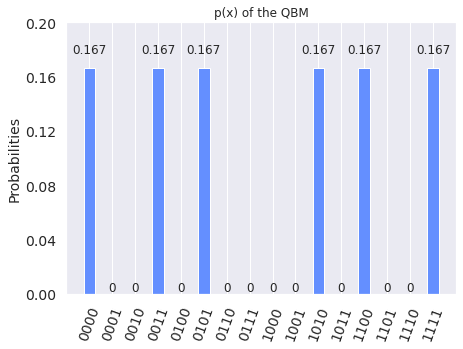

In [142]:
plot_histogram(dict_px_output, title='p(x) of the QBM') #plot the distribution of interest

###  Design a Variational Quantum Circuit (Layer)

The QBM design based on [3](#References) requires a Variational Quantum Circuit or [ansatz](https://qiskit.org/documentation/tutorials/circuits_advanced/01_advanced_circuits.html) that we can name as a layer and this can be repeated L times in order to obtain the desired distribution, in our case of **px_output**.

Qiskit has some ansatz already implemented as is the case of [RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html), for this method requires the parameters number of qubits and the number of repetitions or *L* number of layers.

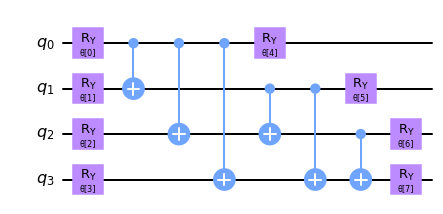

In [143]:
# import for the ansatz is in circuit.library from qiskit
from qiskit.circuit.library import RealAmplitudes

#this ansatz only need the number of the qubits  and the repetitions
ansatz_example = RealAmplitudes(num_qubits, reps=1) 

ansatz_example.draw("mpl")

It is important to know that there are other ansatz other than RealAmplitudes in Qiskit [here](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits), except for this tutorial it will be based on an ansatz that follows the idea of the paper [3](#References),"in this work, we use arbitrary single qubit rotations for the odd layers, and Mølmer-Sørensen XX gates for the even layers", we need remark the paper works in a trapped ion architecture. Design the ansatzes must use [ParameterVector](https://qiskit.org/documentation/stubs/qiskit.circuit.ParameterVector.html) class, in order to generate gates that can vary their values.


<div class="alert alert-block alert-info"><b>Question </b> What happens if we use a predefined ansatz for this problem? </div> 

In [144]:
## Design any ansatz
# In this work, we use arbitrary single qubit rotations for the odd layers, and Mølmer-Sørensen XX gates for the even layers
#
def ansatz_odd(n,parameters): # arbitrary single qubit rotations is the odd layer
    qc = QuantumCircuit(n) 
    
    for i in range(n):
        qc.u(parameters[3*i],parameters[1+(3*i)],parameters[2+(3*i)],i) #variable value for ry with the values parameters[i]
    return qc

def ansatz_even(n,parameters): # Mølmer-Sørensen XX gates for the even layer
    qc = QuantumCircuit(n)
    k = n//2
    for i in range(k):
        qc.rxx(parameters[i],i*2,(2*i)+1)
    for i in range(k):
        qc.rxx(parameters[i+k],k-i-1,k)
    for i in range(k):
        qc.rxx(parameters[i+k*2],k-i-1,k+1)

    return qc

The odd layer is possible consider the arbitrary single qubit rotation has the form $U\left(\theta_{l}^{j}\right)=R_{z}\left(\theta_{l}^{j, 1}\right) R_{x}\left(\theta_{l}^{j, 2}\right) R_{z}\left(\theta_{l}^{j, 3}\right)$. This is possible if we use the [U gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.UGate.html), with a list of parameters.

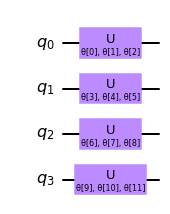

In [145]:
# depents of own design we can change the num_parameters value
num_parameters_odd = 12 #how is 4 qubits we required 12 parametrs
parameters_odd = ParameterVector('θ', num_parameters_odd) # define the vector θ

ansatz_odd(num_qubits,parameters_odd).draw("mpl") # draw own odd layer

For the case of the even layer, MGS XX can be represented in [4](#References), it tells us that from the gate summation RXX($\theta$) in all qubits of the quantum circuit we can obtain such a circuit.

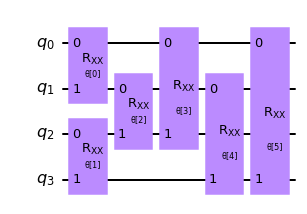

In [146]:
num_parameters_even = 6 #how is 4 qubits we required 6 parametrs
parameters_even = ParameterVector('θ', num_parameters_even) # define the vector θ

ansatz_even(num_qubits,parameters_even).draw("mpl") # draw own  even layer

###  Applying n layers

Due to a Qiskit method in the QuantumCircuit object our both ansatz can be converted into a quantum gate and we can indicate the number of repeats with the variable **num_layers** that are required to fit the expected output distribution.

In [151]:
## ansatz to quantum gate
def gate_layer(n, params,flag):
    if flag == 1:
        parameters = ParameterVector('θ', num_parameters_odd)
        qc = ansatz_odd(n,parameters) #call the odd layer
    else:
        parameters = ParameterVector('θ', num_parameters_even)
        qc = ansatz_even(n,parameters) #call the even layer
    params_dict = {}
    j = 0
    for p in parameters:
        #The name of the value will be the string identifier and an integer specifying the vector length
        params_dict[p] = params[j] 
        j += 1
    #Assign parameters using the assign_parameters method
    qc = qc.assign_parameters(parameters = params_dict)
    qc_gate = qc.to_gate()
    qc_gate.name = "layer" # To show when we display the circuit
    return qc_gate #return a quantum gate


We are going to make a quantum circuit with 3 layers, at the same time it is important to consider that there are two gates that are interleaved for each layer and these have different amount of parameters, so we look for the one that has more of these, i.e. 
```max(paremers_odd,parameters_even)```, and that only the necessary ones are read per layer.

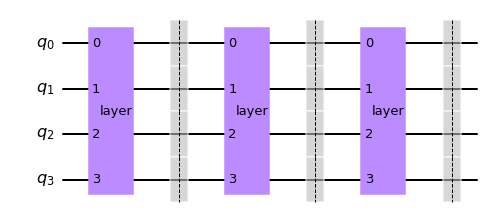

In [155]:
# example of a quantum circuit

num_layers = 3
list_n = range(num_qubits)

num_layers

num_parameters = max(num_parameters_odd,num_parameters_even)

params = np.random.random([num_layers*num_parameters]) #all the parameters
qc_gate = QuantumCircuit(num_qubits)


for i in range(len(params)//num_parameters):
    #apply a function to consider m layers
    qc_gate.append(gate_layer(num_qubits,params[num_parameters*i:num_parameters*(i+1)],(i+1)%2),list_n)
    qc_gate.barrier()
qc_gate.draw("mpl")

In order to verify that they are interleaving we use the decompose() method, to see that the same circuit is repeated in layer 1 and layer 3, using the odd layer, and the second circuit is the even layer.

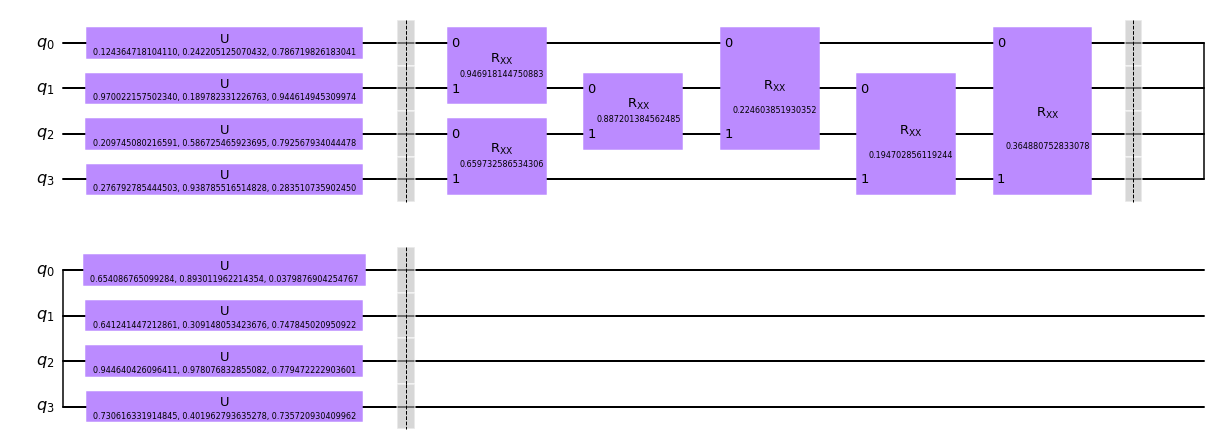

In [156]:
qc_gate.decompose().draw("mpl")

<div class="alert alert-block alert-info"><b>Suggestion </b> play with the number of layers and see how is the draw output </div> 

###  Build all the algorithm

At this point we have the data mapping process and the quantum circuit that represents the QBM, for this we need the optimization section and the cost function to be evaluated, for this we use the advantages of quantum computing in the model and the classical one in the optimization, as shown in Figure 6.




<center>Figure 6. Hybrid algorithm process.</center>

###   Cost Function

Consider the data set BAS, our goal is obtain an approximation to the target probability distribution **px_output** or $P(\mathbf{x})$ . This is possible with a quantum circuit with gates parametrized by a vector $\boldsymbol{\theta}$,where the layer index $l$ runs from 0 to $d$, with $d$ the maximum depth of the quantum circuit [5](#References), prepares a wave function $|\psi(\boldsymbol{\theta})\rangle$ from which probabilities are obtained to $P(\mathbf{x})=|\langle\mathbf{x} \mid \psi(\boldsymbol{\theta})\rangle|^{2}$.Minimization of this quantity is directly related to the minimization of a well known cost function: the negative [log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function) $\mathcal{C}(\boldsymbol{\theta})=-\frac{1}{D} \sum_{d=1}^{D} \ln \left(P\left(\mathbf{x}^{(d)}\right)\right) .$ Is important consider that all the probabilities are estimated from a finite number of measurements and a way to avoid singularities in the cost function [3](#References), we use a simple variant


$\mathcal{C}(\boldsymbol{\theta})=-\frac{1}{D} \sum_{d=1}^{D} \ln \left(\max \left(\varepsilon, P_{\boldsymbol{\theta}}\left(\mathbf{x}^{(d)}\right)\right)\right)$ (3) 

 where $\epsilon>0 $ is a small number to be chosen. Following this equation we have a method called **boltzman_machine(params)**, which is the function that integrates all the quantum process and the cost function required to perform the optimization.

In [70]:
def boltzman_machine(params):
    n=4
    D = int(n**2)
    cost = 0
    list_n = range(n)
    
    qc = QuantumCircuit(n)
    for i in range(len(params)//num_parameters):
        qc.append(gate_layer(n,params[num_parameters*i:num_parameters*(i+1)],(i+1)%2),list_n)
    shots= 8192
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, simulator).result()
    statevector = result.get_statevector(qc)
    for j in range(D):
        cost +=(np.log10(max(0.001,statevector[j].real*px_output[j].real+(statevector[j].imag*px_output[j].imag))))
    cost = -cost/D
    #print(cost)
    return cost

num_layers = 6
params = np.random.random([num_layers*num_parameters])    
boltzman_machine(params)

2.6191698541984523

Having the quantum process that returns the cost, we use the classical process implemented in Qiskit, which has a series of classical [optimizers](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html).

Consider 10 epoch with 500 iterations.

In [71]:
cost_cobyla = []
cost_nm = []
cost_spsa = []

params_cobyla = params
params_nm = params
params_spsa = params
epoch = 10
maxiter = 500

for i in range(epoch):
    optimizer_cobyla = COBYLA(maxiter=maxiter)
    ret = optimizer_cobyla.optimize(num_vars=len(params),objective_function=boltzman_machine, initial_point=params_cobyla)
    params_cobyla = ret[0]
    cost_cobyla.append(ret[1])
    
    optimizer_nm = NELDER_MEAD(maxiter=maxiter)
    ret = optimizer_nm.optimize(num_vars=len(params),objective_function=boltzman_machine, initial_point=params_nm)
    params_nm = ret[0]
    cost_nm.append(ret[1])
    
    optimizer_spsa = SPSA(maxiter=maxiter)
    ret = optimizer_spsa.optimize(num_vars=len(params),objective_function=boltzman_machine, initial_point=params_spsa)
    params_spsa = ret[0]
    cost_spsa.append(ret[1])

From the plot of each result we can see that the best optimizer is COBYLA for this algorithm.

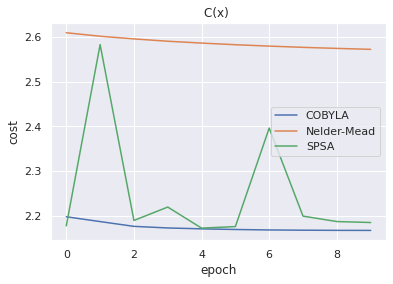

In [72]:
xfit = range(epoch)
plt.plot(xfit, cost_cobyla, label='COBYLA')
plt.plot(xfit, cost_nm, label='Nelder-Mead')
plt.plot(xfit, cost_spsa, label='SPSA')

plt.legend()
plt.title("C(x) ")
plt.xlabel("epoch")
plt.ylabel("cost")
plt.show()

 Qiskit has the opportunity to be able to work with more optimisers that are [here](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html) .

 
<div class="alert alert-block alert-info"><b>Suggestion </b> Try changing the value of the **maxiter** variable and the optimisers in order to identify the best case.  </div> 

the boltzman_machine_valid method is performed to give us  $P(\mathbf{x})=|\langle\mathbf{x} \mid \psi(\boldsymbol{\theta})\rangle|^{2}$

In [73]:
def boltzman_machine_valid(params):
    n=4
    list_n = range(n)
    qc = QuantumCircuit(n)
    for i in range(len(params)//num_parameters):
        qc.append(gate_layer(n,params[num_parameters*i:num_parameters*(i+1)],(i+1)%2),list_n)
    shots= 8192
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, simulator).result()
    #statevector = result.get_statevector(qc)

    return result



###   Viualization
We obtain the output of the three different optimizers

In [74]:
psi_vqc_spsa =  boltzman_machine_valid(params_spsa)
psi_spsa = psi_vqc_spsa.get_statevector()

psi_vqc_nm =  boltzman_machine_valid(params_nm)
psi_nm = psi_vqc_nm.get_statevector()

psi_vqc_cobyla =  boltzman_machine_valid(params_cobyla)
psi_cobyla = psi_vqc_cobyla.get_statevector()

In order to compare all the results of each optimizer with the expected output, the plot_histogram method is used and we can see at a glance the similarities of each distribution.

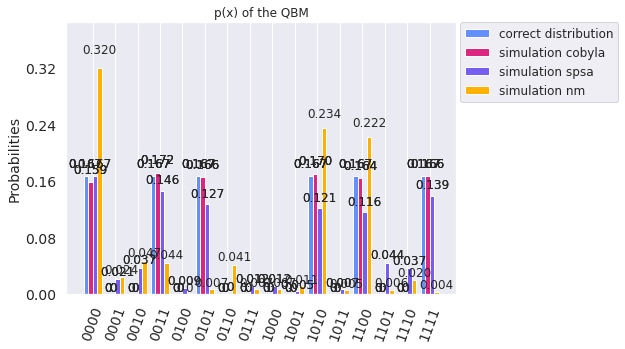

In [75]:
psi_dict_cobyla = psi_vqc_cobyla.get_counts()
psi_dict_spsa = psi_vqc_spsa.get_counts()
psi_dict_nm = psi_vqc_nm.get_counts()

plot_histogram([dict_px_output,psi_dict_cobyla,psi_dict_spsa,psi_dict_nm], title='p(x) of the QBM',
               legend=['correct distribution', 'simulation cobyla','simulation spsa','simulation nm'])

It can be seen that of all the visualization methods, the closest is the one used with COBYLA, which will be considered to generate new samples from this dataset. But you are still invited to look for other optimizers and change the number of the maxiter variable.

###  Using our QBM 

To apply this circuit we use the final parameters and see what kind of results they produce as images. This is shown below.

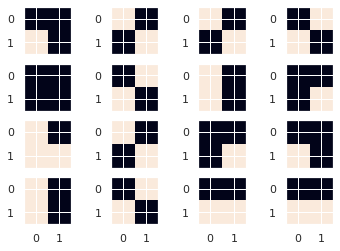

In [76]:
def boltzman_machine_valid_random(params):
    n=4
    list_n = range(n)
    qc = QuantumCircuit(n,n)
    for i in range(len(params)//num_parameters):
        qc.append(gate_layer(n,params[num_parameters*i:num_parameters*(i+1)],(i+1)%2),list_n)
    
    qc.measure(list_n,list_n)
    shots= 1 #Number of shots
    job = execute( qc, Aer.get_backend('qasm_simulator'),shots=shots )
    counts = job.result().get_counts() #Count the results of the execution
    return counts.keys()


matrix = np.zeros((2,2))
for i in range(0,16):
    img = list(boltzman_machine_valid_random(params))[0]
    matrix[0][0] = int(img[0])
    matrix[0][1] = int(img[1])
    matrix[1][0] = int(img[2])
    matrix[1][1] = int(img[3])
    

    
    plt.subplot(4 , 4 , 1+i)
    plt.imshow(matrix)
plt.show()


<div class="alert alert-block alert-danger"> Check how many images do not follow the expected distribution. </div>

Depending on the Dial distributor we expect with higher probability the desired states, but if there is a percentage of an incorrect state it may sometimes appear with its respective probability.


### Noise model

We managed to realize a quantum circuit that is a QBM and to see its effectiveness in a more complex environment than the simulation we will perform the process in a noise model, for this we must consider having our paltaform key in our system.

For this example we will use the real ibmq_lima gate, but you can choose from the ones found [here](https://quantum-computing.ibm.com/services?services=systems).

In [77]:
# In case your need to work this part you need to verfy that your computer has the acces to the real quantum computing
#using your API KEY
#IBMQ.save_account("your key")

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_lima')

We can use the ibmq_lima features for our simulator and it can perform at the same characteristics of this one. 

To know more about the features of the NoiseModel method [here](https://qiskit.org/documentation/stubs/qiskit.providers.aer.noise.NoiseModel.html?highlight=noisemodel)

In [78]:
from qiskit.providers.aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

We performed the same process that we did previously in simulation but adapted it with the noise model variables.

In [82]:
def noise_boltzman_machine(params):
    n=4
    D = int(n**2)
    cost = 0
    list_n = range(n)
    
    qc = QuantumCircuit(n)
    for i in range(len(params)//num_parameters):
        qc.append(gate_layer(n,params[num_parameters*i:num_parameters*(i+1)],(i+1)%2),list_n)
    shots= 8192
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, simulator,
                    coupling_map=coupling_map, #this parameter is important for using a noise model
                    basis_gates=basis_gates,   #this parameter is important for using a noise model
                    noise_model=noise_model,   #this parameter is important for using a noise model
                    shots = 8192,
                    cals_matrix_refresh_period=30).result()
                    
    statevector = result.get_statevector(qc)
    for j in range(D):
        cost +=(np.log10(max(0.001,statevector[j].real*px_output[j].real+(statevector[j].imag*px_output[j].imag))))
    cost = -cost/D
    #print(cost)
    return cost

num_layers = 6
noise_params = np.random.random([num_layers*num_parameters])    
noise_boltzman_machine(noise_params)

2.3349179255815122

Consider run but using a new variable call **noise_params**, and we can consider the best optimizer,**COBYLA** in stead of using the others one.

In [84]:
print("cost")
print(noise_boltzman_machine(noise_params))

for i in range(10):
    optimizer = COBYLA(maxiter=500)
    ret = optimizer.optimize(num_vars=len(noise_params),objective_function=noise_boltzman_machine, initial_point=noise_params)
    noise_params = ret[0]
    print(ret[1])
    

cost
2.1906324522949894
2.187663435996714
2.184635045199487
2.1825602875677235
2.1817413271643002
2.181342476248001
2.1845900983994135
2.182298301548157
2.1822743679319814
2.1817341523213285
2.1812168793613527


At this point we have the distribution $P(x)$ result of the Noise model

In [85]:
noise_psi_vqc = boltzman_machine_valid(noise_params)
noise_psi_vqc.get_statevector()

array([ 0.37024921-0.01208284j,  0.0710299 -0.06875748j,
        0.06416609+0.03909545j,  0.37277806-0.00284012j,
        0.06079699-0.02971354j, -0.23644913-0.05821884j,
        0.3767255 -0.00176292j,  0.06410179-0.02093764j,
        0.07542915+0.02364911j,  0.37047924-0.00369302j,
        0.15427481-0.17399996j,  0.09551802+0.01749377j,
        0.3749134 -0.00590876j,  0.07151214-0.01650527j,
        0.03523511+0.04053334j,  0.37698089+0.00507604j])

The expected output, the best simulated result and the best simulated result using a NoiseModel are compared.

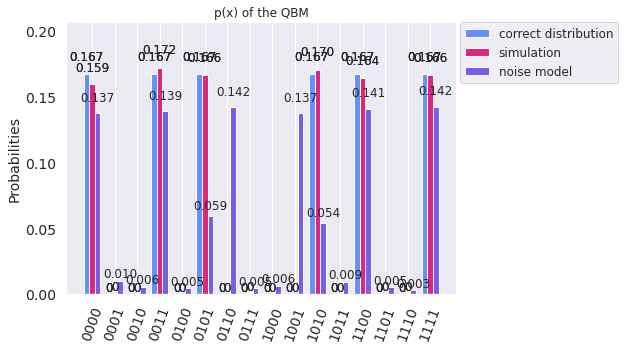

In [86]:
noise_model_psi = noise_psi_vqc.get_counts()
plot_histogram([dict_px_output,psi_dict_cobyla, noise_model_psi], title='p(x) of the QBM',
               legend=['correct distribution', 'simulation','noise model'])

Having each result follow the trend of the expected output, but with certain errors, we can see that our circuit is working, and we can continue this by trying to obtain new samples from the circuit with noise.

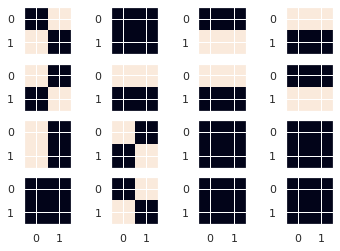

In [87]:
matrix = np.zeros((2,2))
for i in range(0,16):
    img = list(boltzman_machine_valid_random(noise_params))[0]
    matrix[0][0] = int(img[0])
    matrix[0][1] = int(img[1])
    matrix[1][0] = int(img[2])
    matrix[1][1] = int(img[3])    
    plt.subplot(4 , 4 , 1+i)
    plt.imshow(matrix)
plt.show()


<div class="alert alert-block alert-danger"> Check how many images do not follow the expected distribution. </div>

###  Real quantum computer

The quantum instance for real free quantum computer (try to change the value for  provider.get_backend( )), in this tutorial we use the ibmq_lima the same that i nthe noise model. More information about this quantum computer you can find [here](https://quantum-computing.ibm.com/services?services=systems&system=ibmq_lima).

In [88]:
real_backend = provider.get_backend('ibmq_lima') # select the name of the quatum computer to use
print("real device:",real_backend.name())

real device: ibmq_lima


We follow the same processing of the simulation, but in this case we use the backend which is the real computer.

In [89]:
def real_boltzman_machine(params):
    n=4
    D = int(n**2)
    cost = 0
    list_n = range(n)
    
    qc = QuantumCircuit(n,n)
    for i in range(len(params)//num_parameters):
        qc.append(gate_layer(n,params[num_parameters*i:num_parameters*(i+1)],(i+1)%2),list_n)
    qc.measure(list_n,list_n)
    shots= 8192
    result = execute(qc, real_backend,
                    shots = 8192).result()
                    
    counts = result.get_counts(qc)
    for j in range(D):
        bin_index = bin(j)[2:]
        while len(bin_index) < 4:
            bin_index = '0' + bin_index
        statevector_index = counts[bin_index]/8192
        cost +=(np.log10(max(0.001,statevector_index*px_output[j].real)))
    cost = -cost/D
    #print(cost)
    return cost

num_layers = 6
real_params = np.random.random([num_layers*num_parameters])    
real_boltzman_machine(real_params)

2.4798670392506112

For this process being a real free computer, anyone with their IBM account can use any of the free computers, so the process can take some time, for this tutorial we will only use **10 iterations**.

In [90]:
print("cost")
print(real_boltzman_machine(real_params))

for i in range(1):
    optimizer = COBYLA(maxiter=10)
    ret = optimizer.optimize(num_vars=len(real_params),objective_function=real_boltzman_machine, initial_point=real_params)
    real_params = ret[0]
    print(ret[1])

cost
2.483554374879622
2.4716307504310175


In this point we have the result of the real quantum computer for  our QBM.

In [91]:
real_psi_vqc = boltzman_machine_valid(real_params)
real_psi_vqc.get_statevector()

array([-0.11744237-0.04143644j, -0.21963032+0.04731144j,
        0.12949356-0.24230889j, -0.11576072-0.19445749j,
        0.13663278-0.17829584j, -0.12344571-0.23925038j,
        0.06643471-0.0690185j ,  0.02258557-0.21092437j,
        0.28652185-0.18236651j, -0.31492366-0.14635642j,
        0.29619161-0.02872149j, -0.14718869-0.13642852j,
        0.14361905+0.12780284j, -0.06109766-0.21951445j,
        0.31892088+0.20029974j, -0.00947203-0.18607355j])

We can compare all the result in a same plot_histogram, and check the worst case is the result of the quantum real computer, that could be solve, using more iteration, mitigate the error, modified the ansatz or both.

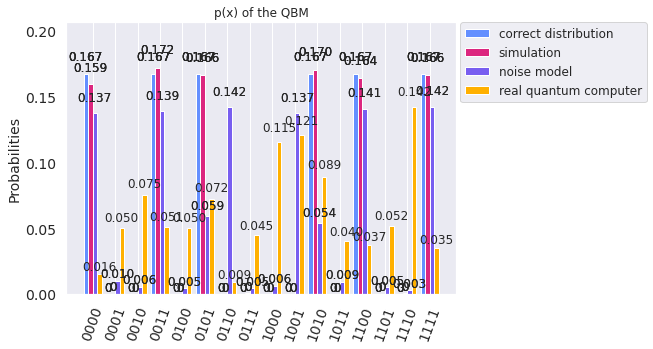

In [92]:
real_model_psi = real_psi_vqc.get_counts()
plot_histogram([dict_px_output,psi_dict_cobyla, noise_model_psi,real_model_psi], title='p(x) of the QBM',
               legend=['correct distribution', 'simulation','noise model', 'real quantum computer'])

Just to confirm what are the possible outputs of our circuit using the real computer, this is given by the type of distribution obtained from the computer.

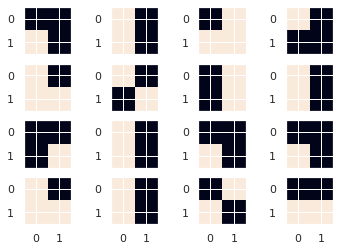

In [93]:
matrix = np.zeros((2,2))
for i in range(0,16):
    img = list(boltzman_machine_valid_random(real_params))[0]
    matrix[0][0] = int(img[0])
    matrix[0][1] = int(img[1])
    matrix[1][0] = int(img[2])
    matrix[1][1] = int(img[3])
    

    
    plt.subplot(4 , 4 , 1+i)
    plt.imshow(matrix)
plt.show()


<div class="alert alert-block alert-danger"> Check how many images do not follow the expected distribution. </div>

##  Another perspective

For this part we can do the same procces and using the reference [5](#References) with the proposal to design another Ansatz model, the characteristics are:

- Using the same layer arbitrary rotation gate, 
- And employ CNOT gates with no parameters for the entangle layers.

The new ansatz it could be 

In [123]:
## Design any ansatz
# In this work, we use arbitrary single qubit rotations for the odd layers, and Mølmer-Sørensen XX gates for the even layers
#
def ansatz_layer(n,parameters): # this ansatz is equivalent a layer
    qc = QuantumCircuit(n) 
    
    for i in range(n):
        qc.u(parameters[i*3],parameters[(i*3)+1],parameters[(i*3)+2],i) #variable value for ry with the values parameters[i]
    for i in range(n-1):
        qc.cx(i,i+1)
        
    return qc

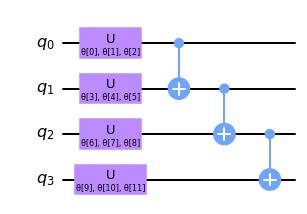

In [125]:
# depents of own design we can change the num_parameters value
num_parameters_v2 = 12 #how is 4 qubits we required 12 parametrs
parameters_v2 = ParameterVector('θ', num_parameters_v2) # define the vector θ

ansatz_layer(num_qubits,parameters_v2).draw("mpl") # draw own odd layer

We apply this ansatz how an gate like the previous part, how is only a gate we don't now use the parameter flag

In [163]:
## ansatz to quantum gate
def gate_layer_v2(n, params):
    parameters = ParameterVector('θ', num_parameters_v2)
    qc = ansatz_layer(n,parameters) #call the new layer version 2
    params_dict = {}
    j = 0
    for p in parameters:
        #The name of the value will be the string identifier and an integer specifying the vector length
        params_dict[p] = params[j] 
        j += 1
    #Assign parameters using the assign_parameters method
    qc = qc.assign_parameters(parameters = params_dict)
    qc_gate = qc.to_gate()
    qc_gate.name = "layer" # To show when we display the circuit
    return qc_gate #return a quantum gate


We are going to make a quantum circuit with 3 layers, where each gate are the same structure.

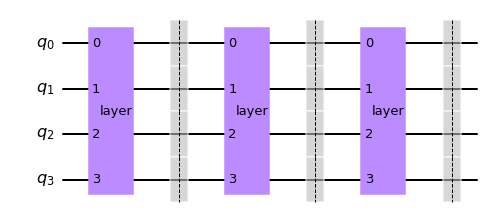

In [164]:
# example of a quantum circuit

num_layers = 3
list_n = range(num_qubits)

num_layers


params = np.random.random([num_layers*num_parameters_v2]) #all the parameters
qc_gate = QuantumCircuit(num_qubits)


for i in range(len(params)//num_parameters):
    #apply a function to consider m layers
    qc_gate.append(gate_layer_v2(num_qubits,params[num_parameters_v2*i:num_parameters_v2*(i+1)]),list_n)
    qc_gate.barrier()
qc_gate.draw("mpl")

Now we are using decompose(), it is observed that if the new structure consists of the same circuit for each layer.

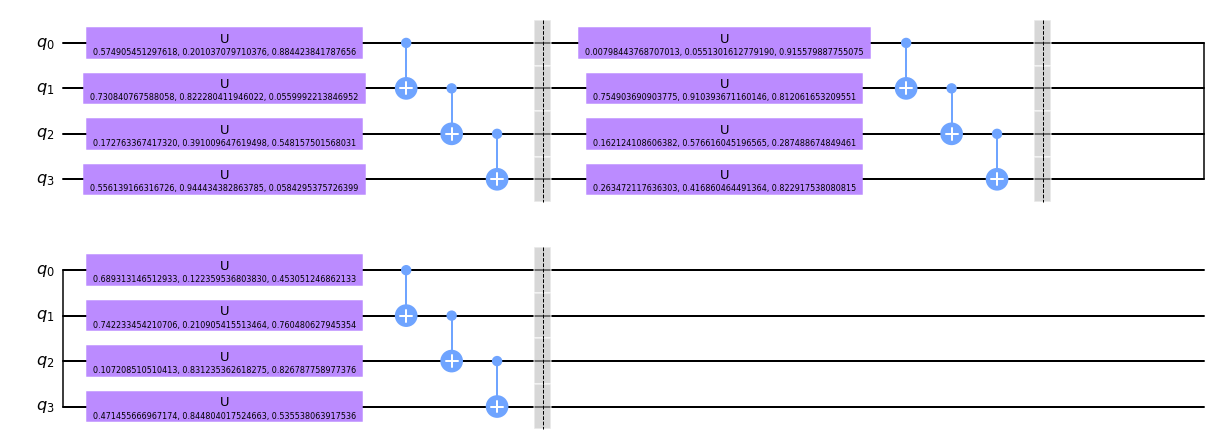

In [166]:
qc_gate.decompose().draw("mpl")

###  Experiments

As in the previous section, we will train with simulation. In this ansatz we are using only 3 layers

In [174]:
def boltzman_machine_v2(params):
    n=4
    D = int(n**2)
    cost = 0
    list_n = range(n)
    
    qc = QuantumCircuit(n)
    for i in range(len(params)//num_parameters):
        qc.append(gate_layer_v2(n,params[num_parameters*i:num_parameters*(i+1)]),list_n)
    shots= 8192
    simulator = Aer.get_backend('statevector_simulator')
    result = execute(qc, simulator).result()
    statevector = result.get_statevector(qc)
    for j in range(D):
        cost +=(np.log10(max(0.001,statevector[j].real*px_output[j].real+(statevector[j].imag*px_output[j].imag))))
    cost = -cost/D
    #print(cost)
    return cost

num_layers = 3
params = np.random.random([num_layers*num_parameters])    
boltzman_machine_v2(params)

2.6521973430139036

In [176]:
cost_cobyla = []
cost_nm = []
cost_spsa = []

params_cobyla = params
params_nm = params
params_spsa = params
epoch = 10
maxiter = 500

for i in range(epoch):
    optimizer_cobyla = COBYLA(maxiter=maxiter)
    ret = optimizer_cobyla.optimize(num_vars=len(params),objective_function=boltzman_machine_v2, initial_point=params_cobyla)
    params_cobyla = ret[0]
    cost_cobyla.append(ret[1])
    
    optimizer_nm = NELDER_MEAD(maxiter=maxiter)
    ret = optimizer_nm.optimize(num_vars=len(params),objective_function=boltzman_machine_v2, initial_point=params_nm)
    params_nm = ret[0]
    cost_nm.append(ret[1])
    
    optimizer_spsa = SPSA(maxiter=maxiter)
    ret = optimizer_spsa.optimize(num_vars=len(params),objective_function=boltzman_machine_v2, initial_point=params_spsa)
    params_spsa = ret[0]
    cost_spsa.append(ret[1])

The process is repeated to confirm the best optimizer using this new ansatz

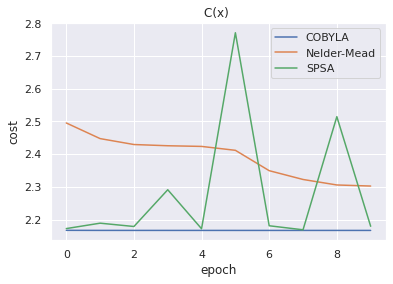

In [177]:
xfit = range(epoch)
plt.plot(xfit, cost_cobyla, label='COBYLA')
plt.plot(xfit, cost_nm, label='Nelder-Mead')
plt.plot(xfit, cost_spsa, label='SPSA')

plt.legend()
plt.title("C(x) ")
plt.xlabel("epoch")
plt.ylabel("cost")
plt.show()

It is reconfirmed that the best case is using COBYLA

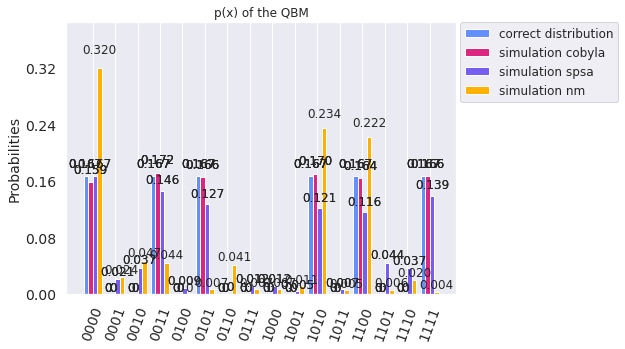

In [178]:
psi_dict_cobyla = psi_vqc_cobyla.get_counts()
psi_dict_spsa = psi_vqc_spsa.get_counts()
psi_dict_nm = psi_vqc_nm.get_counts()

plot_histogram([dict_px_output,psi_dict_cobyla,psi_dict_spsa,psi_dict_nm], title='p(x) of the QBM',
               legend=['correct distribution', 'simulation cobyla','simulation spsa','simulation nm'])

Applying now the distribution obtained from the simulation result

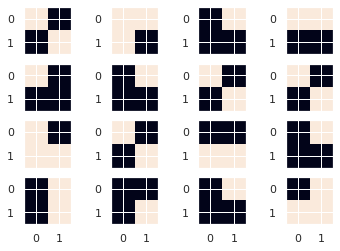

In [180]:
def boltzman_machine_valid_random_v2(params):
    n=4
    list_n = range(n)
    qc = QuantumCircuit(n,n)
    for i in range(len(params)//num_parameters):
        qc.append(gate_layer(n,params[num_parameters*i:num_parameters*(i+1)],(i+1)%2),list_n)
    
    qc.measure(list_n,list_n)
    shots= 1 #Number of shots
    job = execute( qc, Aer.get_backend('qasm_simulator'),shots=shots )
    counts = job.result().get_counts() #Count the results of the execution
    return counts.keys()

matrix = np.zeros((2,2))
for i in range(0,16):
    img = list(boltzman_machine_valid_random_v2(params_cobyla))[0]
    matrix[0][0] = int(img[0])
    matrix[0][1] = int(img[1])
    matrix[1][0] = int(img[2])
    matrix[1][1] = int(img[3])
    

    
    plt.subplot(4 , 4 , 1+i)
    plt.imshow(matrix)
plt.show()


<div class="alert alert-block alert-danger"> Check how many images do not follow the expected distribution. </div>

<div class="alert alert-block alert-success"><b> Exercise </b> Redesign the methods for the noise model and the real computer and see what the results are.  </div> 

<div class="alert alert-block alert-info"><b> Suggestion </b> 
    
   <ul><li> Modify the ansatz or use a new ansatz and apply with a simulation, noise model and real quantum computer.</li>
       <li>
You can use a 3x3 or 4x4 image for that consider reference [5](#References).</li></ul></div> 




##  References

1. Amin, Mohammad & Andriyash, Evgeny & Rolfe, Jason & Kulchytskyy, Bohdan & Melko, Roger. (2016). Quantum Boltzmann Machine. Physical Review X. 8. 10.1103/PhysRevX.8.021050 [https://arxiv.org/pdf/1601.02036.pdf](https://arxiv.org/pdf/1601.02036.pdf) .

2. Zoufal, Christa & Lucchi, Aurelien & Woerner, Stefan. (2021). Variational quantum Boltzmann machines. Quantum Machine Intelligence. 3. 10.1007/s42484-020-00033-7 [https://arxiv.org/pdf/2006.06004.pdf](https://arxiv.org/pdf/2006.06004.pdf). 

3. Benedetti, Marcello & Garcia-Pintos, Delfina & Nam, Yunseong & Perdomo-Ortiz, Alejandro. (2018). A generative modeling approach for benchmarking and training shallow quantum circuits. npj Quantum Information. 5. 10.1038/s41534-019-0157-8. [https://arxiv.org/pdf/1801.07686.pdf](https://arxiv.org/pdf/1801.07686.pdf) [paper](https://www.nature.com/articles/s41534-019-0157-8)

4. Rudolph, Manuel & Bashige, Ntwali & Katabarwa, Amara & Johr, Sonika & Peropadre, Borja & Perdomo-Ortiz, Alejandro. (2020). Generation of High Resolution Handwritten Digits with an Ion-Trap Quantum Computer. [https://arxiv.org/pdf/2012.03924.pdf](https://arxiv.org/pdf/2012.03924.pdf)

5. Jinguo, Liu & Wang, Lei. (2018). Differentiable Learning of Quantum Circuit Born Machine. Physical Review A. 98. 10.1103/PhysRevA.98.062324. [https://arxiv.org/pdf/1804.04168.pdf](https://arxiv.org/pdf/1804.04168.pdf)

In [94]:
import qiskit.tools.jupyter
%qiskit_version_table